### *IPCC SR15 scenario assessment*

<img style="float: right; height: 80px; padding-left: 20px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="../_static/IAMC_logo.jpg">

# Global emission pathway characteristics

## Figure 3a of the *Summary for Policymakers*

This notebook extracts the emissions pathways for Figure 3a in the Summary for Policymakers
of the IPCC's _"Special Report on Global Warming of 1.5°C"_.

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

### *Disclaimer*

*The figures shown in this notebook are NOT the same figures as used in Figure 3a of the SPM.
They are simplified figures included here only for reference.*

## Load `pyam` package and other dependencies

In [2]:
import pandas as pd
import numpy as np
import io
import itertools
import yaml
import math
import matplotlib.pyplot as plt
plt.style.use('style_sr15.mplstyle')
%matplotlib inline
import pyam

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Import scenario data, categorization and specifications files

The metadata file with scenario categorisation and quantitative indicators can be downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).  
Alternatively, it can be re-created using the notebook `sr15_2.0_categories_indicators`.

The last cell of this section loads and assigns a number of auxiliary lists as defined in the categorization notebook.

In [3]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r2.0.xlsx')

pyam.utils - INFO: Reading `../data/iamc15_scenario_data_world_r2.0.xlsx`


In [4]:
sr1p5.load_meta('sr15_metadata_indicators.xlsx')

pyam.core - INFO: Importing metadata for 416 scenarios (for total of 416)


In [5]:
with open("sr15_specs.yaml", 'r') as stream:
    specs = yaml.load(stream, Loader=yaml.FullLoader)

rc = pyam.run_control()
rc.update(specs.pop('run_control'))
cats = specs.pop('cats')
cats_15 = specs.pop('cats_15')
cats_15_no_lo = specs.pop('cats_15_no_lo')
marker= specs.pop('marker')

## Downselect scenario ensemble to categories of interest for this assessment

This figure only includes scenarios where the 2010 Kyoto GHG emissions are in line with the valid range as determined by the Second Assessment Report.

In [6]:
sr1p5.meta.rename(columns={'Kyoto-GHG|2010 (SAR)': 'kyoto_ghg_2010'}, inplace=True)

In [7]:
df = sr1p5.filter(category=cats_15, kyoto_ghg_2010='in range')

In [8]:
df.set_meta(meta='1.5C limited overshoot', name='supercategory', index=df.filter(category=cats_15_no_lo))
rc.update({'color': {'supercategory': {'1.5C limited overshoot': 'xkcd:bluish'}}})

## Set specifications for filters and initialize data list

In [9]:
filter_args = dict(df=df, category=cats, marker=None, join_meta=True)

In [10]:
data = []

## Plot different emissions pathways by category

### Net carbon dioxide emissions for all pathways limiting global warming to 1.5°C by the end of the century

In [11]:
co2 = (
    df.filter(variable='Emissions|CO2')
    .convert_unit('Mt CO2/yr', 'Gt CO2/yr')
)
data.append(('Net carbon dioxide', co2))

/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/pyam/plotting.py:738: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  mins = pd.concat([allmins, intermins]).min(level=0)
/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/pyam/plotting.py:745: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  maxs = pd.concat([allmaxs, intermaxs]).max(level=0)


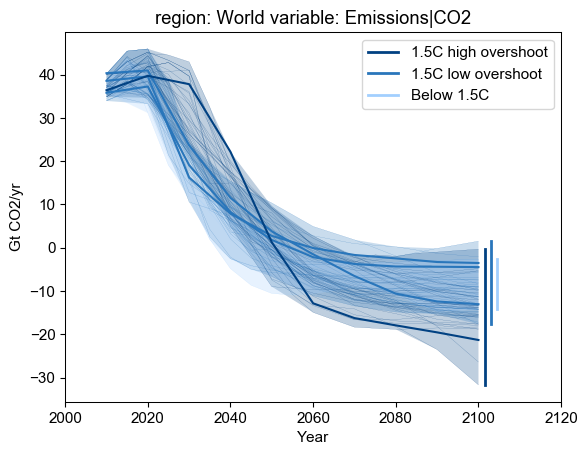

In [12]:
_co2 = co2.filter(category=cats_15, year=range(2010, 2101, 5))

fig, ax = plt.subplots()
_co2.filter(year=[2010]).line_plot(ax=ax, color='category', linewidth=2)
_co2.line_plot(ax=ax, color='category', linewidth=0.1, fill_between=True, final_ranges=True)
_co2.filter(marker=marker).line_plot(ax=ax, color='category')

### Emissions of methane, black carbon and nitrous oxide for 1.5°C pathways with limited overshoot

The figures below are shown as reduction relative to 2010.

In [13]:
def plot_relative(data, baseyear=2010):
    _data = data.timeseries()
    _data_rel = pd.DataFrame()
    for y in range(2010, 2101, 5):
        _data_rel[y] = _data[y] / _data[2010]

    _data_rel.reset_index(inplace=True)
    _data_rel['unit'] = 'relative to {}'.format(baseyear)
    _df = pyam.IamDataFrame(_data_rel)
    _df.set_meta(meta='1.5C limited overshoot', name='supercategory')
    _df.filter(supercategory='1.5C limited overshoot', year=range(2010, 2101, 5))\
        .line_plot(color='supercategory', linewidth=0.1, fill_between=True, legend=False)

In [14]:
ch4 = df.filter(variable='Emissions|CH4')
data.append(('Methane', ch4))

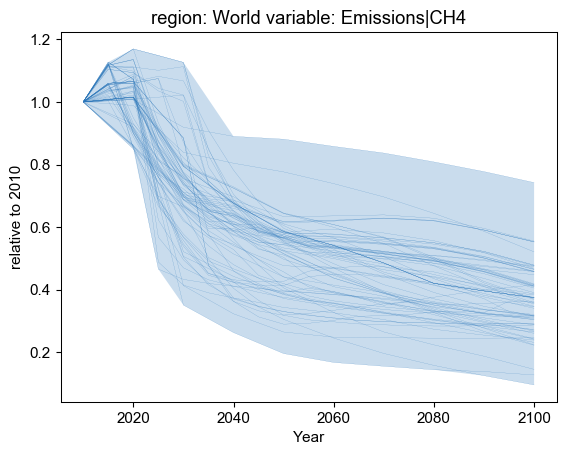

In [15]:
plot_relative(ch4)

In [16]:
bc = df.filter(variable='Emissions|BC')
data.append(('Black carbon', bc))

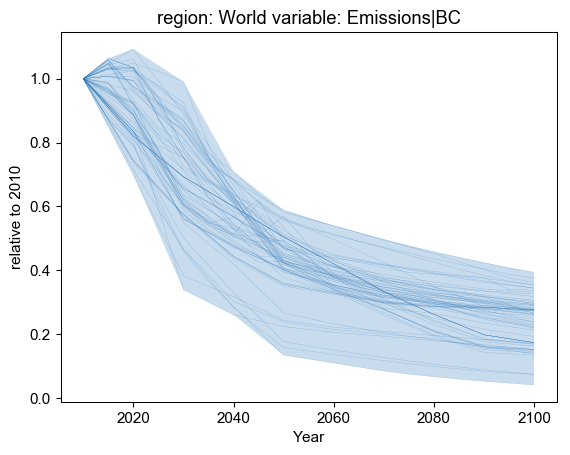

In [17]:
plot_relative(bc)

In [18]:
n2o = df.filter(variable='Emissions|N2O')
n2o.convert_unit('kt N2O/yr', 'Mt N2O/yr', factor=1/1000, inplace=True)
data.append(('Nitrous oxide', n2o))

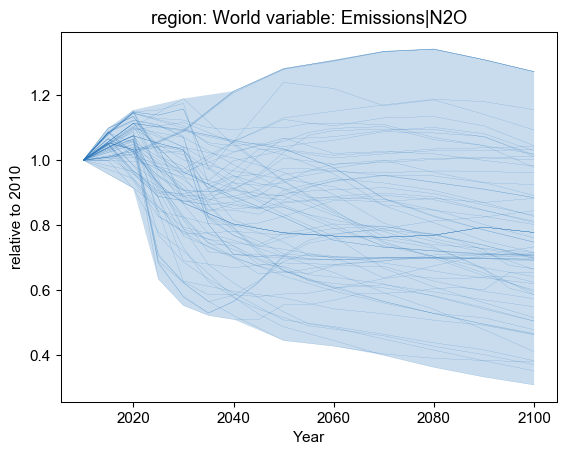

In [19]:
plot_relative(n2o)

## Save timeseries data to `xlsx`

In [20]:
writer = pd.ExcelWriter('output/spm_sr15_figure3a_data_table.xlsx')
for (name, _df) in data:
    pyam.utils.write_sheet(writer, name,
                           pyam.filter_by_meta(_df.timeseries(), **filter_args), index=True)
writer.save()